## Import Packages

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
from rdkit.Chem import PandasTools
import rdkit.Chem.Fragments as Fragments

## Curate Dataset

In [2]:
infile = "../data/combined_training_datasets_unique.sdf"
name = os.path.splitext(os.path.basename(infile))[0]

all_df = PandasTools.LoadSDF(infile)
all_df.head()

[19:11:51] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 13 ignored


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,ROMol
0,6.21,6.09,10,basic,['chembl25'],1702768,<rdkit.Chem.rdchem.Mol object at 0x7fe922d85a10>
1,7.46,8.2,9,basic,['chembl25'],273537,<rdkit.Chem.rdchem.Mol object at 0x7fe8f835a8f0>
2,4.2,3.94,9,basic,['datawarrior'],7175,<rdkit.Chem.rdchem.Mol object at 0x7fe8f835a960>
3,3.73,5.91,8,acidic,['datawarrior'],998,<rdkit.Chem.rdchem.Mol object at 0x7fe8f835a9d0>
4,11.0,8.94,13,basic,['chembl25'],560562,<rdkit.Chem.rdchem.Mol object at 0x7fe8f835aa40>


In [3]:
outfile = f"../data/{name}_training.npy"
patterns = []
for patstr in dir(Chem.Fragments):
    if patstr.startswith("fr"):
        patterns.append(patstr)
print(f"Number of fragment patterns: {len(patterns)}")

PATTERNS = [getattr(Fragments, patstr) for patstr in patterns]

def featurize(mol):
    counts = [pattern(mol) for pattern in PATTERNS]
    return counts

X = []
Y = []

for idx, row in all_df.iterrows():
    x = featurize(row["ROMol"])
    X.append(x)
    Y.append(row["pKa"])
X = np.array(X, dtype=float)
Y = np.array(Y, dtype=float).reshape(-1, 1)

np.save(outfile, np.hstack([X, Y]))

Number of fragment patterns: 85


## Linear Regression

In [68]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

datadir = "."
infile = "../data/combined_training_datasets_unique_training.npy"
ratio = 0.1
epochs = 50
lr = 1e-5

## Load data

In [69]:
arr = np.load(infile)
X, Y = arr[:, :-1], arr[:, -1]
print(f"Shape of X: {X.shape}, shape of Y: {Y.shape}")

Shape of X: (5994, 85), shape of Y: (5994,)


## Split dataset

In [70]:
nsamples = X.shape[0]
val_size = int(nsamples*ratio)
X_train, Y_train = X[:-val_size], Y[:-val_size]
X_test, Y_test = X[-val_size:], Y[-val_size:]
print(f"Size of training set: {X_train.shape[0]}, Size of test set: {X_test.shape[0]}")

Size of training set: 5395, Size of test set: 599


### Normalize dataset

In [71]:
avg = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

normalized_X_train = np.zeros_like(X_train)
normalized_X_test = np.zeros_like(X_test)
for i in range(X_train.shape[1]):
    if np.isclose(std[i], 0):
        normalized_X_train[:, i] = X_train[:, i]
        normalized_X_test[:, i] = X_test[:, i]
    else:
        normalized_X_train[:, i] = (X_train[:, i]-avg[i])/std[i]
        normalized_X_test[:, i] = (X_test[:, i]-avg[i])/std[i]

# include bias in X

X_train = np.hstack([np.ones(normalized_X_train.shape[0]).reshape(-1, 1), normalized_X_train])
X_test = np.hstack([np.ones(normalized_X_test.shape[0]).reshape(-1, 1), normalized_X_test])

ndim = X_train.shape[1]
print(f"Number of samples: {nsamples}, Dimension of features: {ndim}")


Number of samples: 5994, Dimension of features: 86


## Model

### Design model


Assumption: For each $\mathbf{\textit x}\in \mathbb{R}^{N}$, $\textit y = \sum_{j=1}^{N} w_{i}*x_{i} + b$, or $\textit y = \sum_{j=0}^{N} w_{i}*x_{i}$ if combining `bias` to $\mathbf{\textit x}$.

In [72]:
def model(x, w):
    pred = np.dot(x, w)
    return pred

def loss_fn(pred, truth):
    return (pred-truth)**2

def grad_fn(x, pred, truth):
    dw = 2*(pred-truth)*x
    return dw

def optimize(w, dw):
    w -= lr*dw
    return w

### Training

In [73]:
def run_one_epoch():
    global W
    losses = []
    for idx in range(X_train.shape[0]):
        truth = Y_train[idx]
        x = X_train[idx]
        pred = model(x, W)
        l = loss_fn(pred, truth)
        dw = grad_fn(x, pred, truth)
        W = optimize(W, dw)
        losses.append(l)
    return np.mean(losses)

def evaluate():
    global W
    losses = []
    for idx in range(X_test.shape[0]):
        truth = Y_test[idx]
        x = X_test[idx]
        pred = model(x, W)
        l = loss_fn(pred, truth)
        losses.append(l)
    return np.mean(losses)

In [74]:
W = np.zeros(ndim, dtype=float)
train_epoch_losses = []
test_epoch_losses = []
for idx in range(epochs):
    l = run_one_epoch()
    train_epoch_losses.append(l)
    l = evaluate()
    test_epoch_losses.append(l)

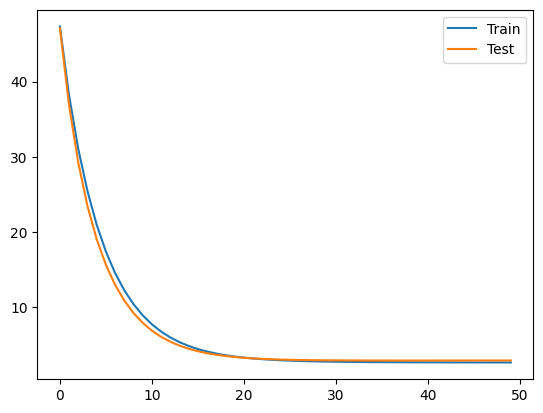

In [75]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

2.897229629978503


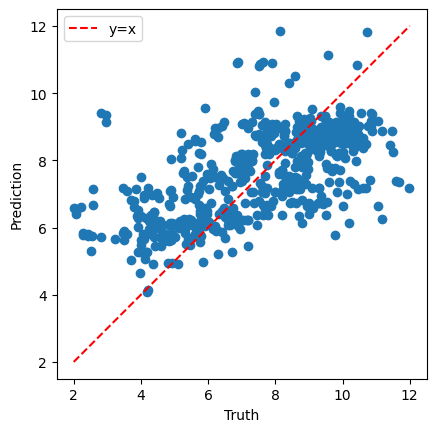

In [76]:
pred, truth = [], []
losses = []
for idx in range(X_test.shape[0]):
    y_hat = model(X_test[idx], W)
    y = Y_test[idx]
    l = loss_fn(y_hat, y)
    pred.append(y_hat)
    truth.append(y)
    losses.append(l)

print(np.mean(losses))

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()

In [77]:
import torch
import torch.nn as nn
l = nn.functional.mse_loss(torch.Tensor(pred), torch.Tensor(truth))
print(l)

tensor(2.8972)
